## Data exploration

In [135]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [136]:
path_data = "./data/BRFSS-2015_binary.csv"
df0 = pd.read_csv(path_data)

In [137]:
df0.head()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,1.0,1.0,40.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,5.0,18.0,15.0,1.0,0.0,9.0,4.0,3.0
1,0.0,0.0,0.0,0.0,25.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,3.0,0.0,0.0,0.0,0.0,7.0,6.0,1.0
2,0.0,1.0,1.0,1.0,28.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,5.0,30.0,30.0,1.0,0.0,9.0,4.0,8.0
3,0.0,1.0,0.0,1.0,27.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,11.0,3.0,6.0
4,0.0,1.0,1.0,1.0,24.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,3.0,0.0,0.0,0.0,11.0,5.0,4.0


### Mapping and functions

In [138]:
mapping_binary = {0: "No", 1: "Yes"}
mapping_genhlth = {1: "Excellent", 2: "Very Good", 3: "Good", 4: "Fair", 5: "Poor"}
mapping_gender = {0: "Female", 1: "Male"}
mapping_age = {1: "18-24", 2: "25-29", 3: "30-34", 4: "35-39", 5: "40-44", 6: "45-49", 7: "50-54", 8: "55-59", 9: "60-64", 10: "65-69", 11: "70-74", 12: "75-79", 13: "80 or older"}
mapping_edu = {
  1: "Never / Kindergarten",
  2: "Elementary",
  3: "Some high school",
  4: "High school graduate",
  5: "Some college / Technical school",
  6: "College graduate"
}
mapping_income = {
  1: "≤$10k",
  2: "\\$10k-$<15k",
  3: "\\$15k-$<20k",
  4: "\\$20k-$<25k",
  5: "\\$25k-$<35k",
  6: "\\$35k-$<50k",
  7: "\\$50k-$<75k",
  8: "≥$75k"
}

In [139]:
def create_order_level(mapping):
    return [mapping[item] for item in range(1,len(mapping)+1)]
order_genhlth = create_order_level(mapping_genhlth)[::-1]
order_age = create_order_level(mapping_age)
order_edu = create_order_level(mapping_edu)
order_income = create_order_level(mapping_income)

In [140]:
def plot_binary(df, target, features, titles, grid_shape, figure_size, bounding_box, mapping=mapping_binary):
    fig, axes = plt.subplots(grid_shape[0], grid_shape[1], figsize=figure_size)
    axes = axes.flatten()
    for i, (feature, title) in enumerate(zip(features, titles)):
        x = df[feature].map(mapping)
        y = df[target]
        df_crosstab = pd.crosstab(x, y, dropna=False, normalize="index")
        df_crosstab.plot.bar(rot=0, ax=axes[i])
        # for container in axes[i].containers:
        #     axes[i].bar_label(container, fmt="%.2f")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("Percentage")
        axes[i].set_title(title, fontsize=10)
        axes[i].legend().remove() 
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right", bbox_to_anchor=bounding_box, bbox_transform=plt.gcf().transFigure)
    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.show()

### Select rows

In [141]:
# Remove age less than 30
conditions = ~(df0.Age.isin([1,2]))
df0 = df0[conditions]

In [142]:
df0.shape

(238501, 22)

### Target

In [143]:
df0["target"] = df0["Diabetes_binary"].map(mapping_binary)

In [144]:
print("The frequency is")
print(df0["target"].value_counts())
print("-----------------")
print("The percentage is")
print(df0["target"].value_counts(normalize=True))

The frequency is
target
No     198817
Yes     39684
Name: count, dtype: int64
-----------------
The percentage is
target
No     0.833611
Yes    0.166389
Name: proportion, dtype: float64


* The dataset is imbalanced
* [The degree of imbalance is moderate](https://developers.google.com/machine-learning/crash-course/overfitting/imbalanced-datasets)

### Features

#### Health
* There are 6 variables related to patients' health: `HighBP`_(binary)_, `HighChol`_(binary)_, `BMI`_(numerical)_, `Stroke`_(binary)_, `HeartDiseaseorAttack`_(binary)_, `DiffWalk`_(binary)_

##### HighBP, HighChol, Stroke, HeartDiseaseorAttack, DiffWalk

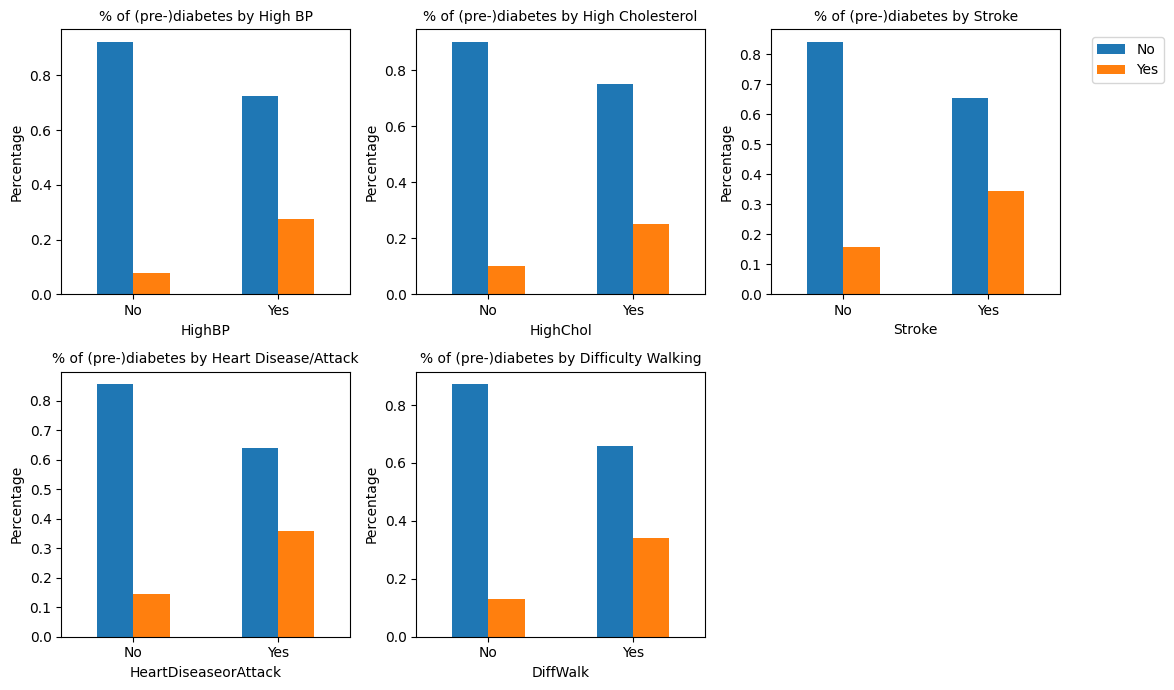

In [145]:
features = ["HighBP", "HighChol", "Stroke", "HeartDiseaseorAttack", "DiffWalk"]
titles = ["High BP", "High Cholesterol", "Stroke", "Heart Disease/Attack", "Difficulty Walking"]
titles = ["% of (pre-)diabetes by " + title for title in titles]
plot_binary(df0, "target", features, titles, grid_shape=(2, 3), figure_size=(12, 7), bounding_box=(0.98, 0.95))

##### BMI

In [146]:
scaler = StandardScaler(with_std=True)
df0["BMI_scaled"] = scaler.fit_transform(df0[["BMI"]]).flatten()

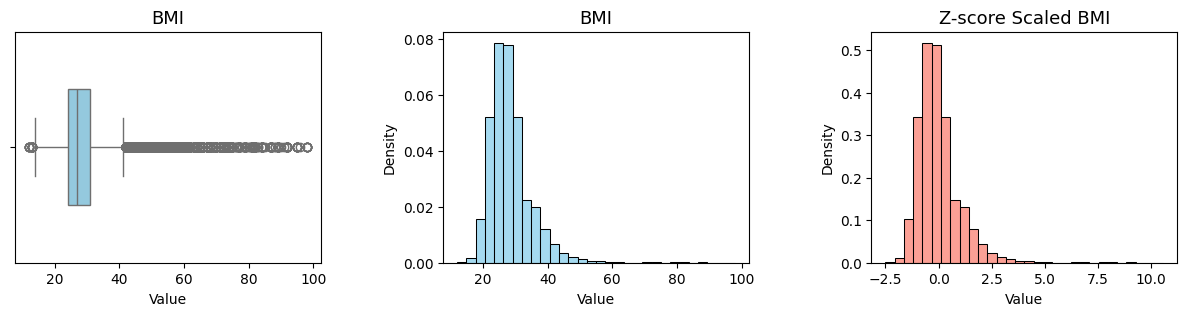

In [147]:
plt.figure(figsize=(15, 3))
plt.subplot(1, 3, 1)
sns.boxplot(x ="BMI", data=df0, orient="h", width=0.5, color="skyblue")
plt.xlabel("Value")
plt.ylabel("")
plt.title("BMI", fontsize=13)

plt.subplot(1, 3, 2)
sns.histplot(x="BMI", data=df0, bins=30, kde=False, color="skyblue", stat="density")
plt.xlabel("Value")
plt.title("BMI", fontsize=13)

plt.subplot(1, 3, 3)
sns.histplot(x="BMI_scaled", data=df0, bins=30, kde=False, color="salmon", stat="density")
plt.xlabel("Value")
plt.title("Z-score Scaled BMI", fontsize=13)

plt.subplots_adjust(wspace=0.4)
plt.show()

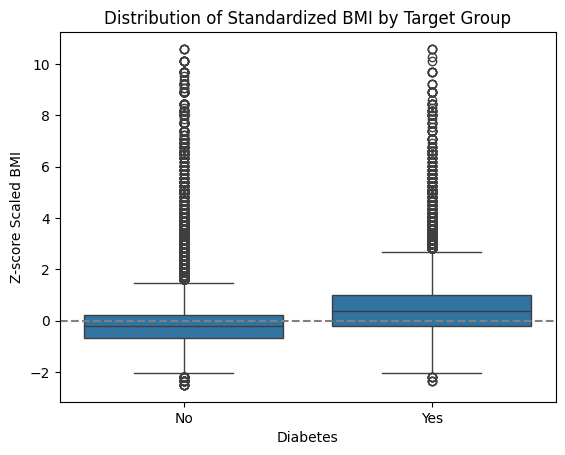

In [148]:
sns.boxplot(x='target', y='BMI_scaled', data=df0)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Distribution of Standardized BMI by Target Group")
plt.xlabel("Diabetes")
plt.ylabel("Z-score Scaled BMI")
plt.show()

#### Perceived health
* There are 3 variables related to preceived health: `GenHlth`_(ordinal)_, `MentHlth`_(numerical)_, `PhysHlth`_(numerical)_

##### GenHlth

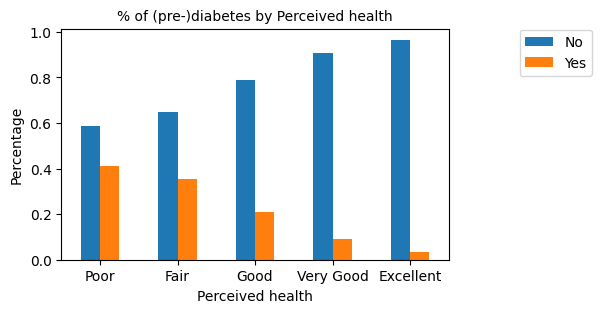

In [149]:
cat_type = pd.CategoricalDtype(categories=order_genhlth, ordered=True)
x = df0["GenHlth"].map(mapping_genhlth).astype(cat_type)

df_crosstab = pd.crosstab(x, df0["target"], dropna=False, normalize="index")
fig, ax = plt.subplots(figsize=(5, 3))
df_crosstab.plot.bar(rot=0, ax=ax)
ax.set_xlabel("Perceived health")
ax.set_ylabel("Percentage")
ax.set_title("% of (pre-)diabetes by Perceived health", fontsize=10)
ax.legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.2, 0.9), bbox_transform=plt.gcf().transFigure)
plt.show()

##### MentHlth

In [150]:
bins = [-1, 0, 7, 14, 21, 28, 30]
labels = ['0', '1-7', '8-14', '15-21', '22-28', '29-30']
df0["PhysHlth_group"] = pd.cut(df0["PhysHlth"], bins=bins, labels=labels)
df0["MentHlth_group"] = pd.cut(df0["MentHlth"], bins=bins, labels=labels)

In [151]:
def compare_day_grouping(feature_before_group, feature_after_group, title):
    # Prepare data for first plot
    df_crosstab1 = df0[feature_before_group].value_counts(normalize=True).sort_index() * 100
    df_crosstab1 = df_crosstab1.to_frame().reset_index(drop=False).rename(columns={"proportion": "percentage"})
    df_crosstab1[feature_before_group] = df_crosstab1[feature_before_group].astype("int64")

    # Prepare data for second plot
    df_crosstab2 = df0[feature_after_group].value_counts(normalize=True).sort_index() * 100
    df_crosstab2 = df_crosstab2.to_frame().reset_index(drop=False).rename(columns={"proportion": "percentage"})

    # Create a figure with GridSpec
    fig = plt.figure(figsize=(11, 3))
    gs = fig.add_gridspec(1, 3)

    # Create the first subplot (2/3 of the figure)
    ax1 = fig.add_subplot(gs[0, :2])
    sns.barplot(data=df_crosstab1, x=feature_before_group, y="percentage", ax=ax1)
    ax1.set_title(f"{title} before grouping")
    ax1.set_xlabel("Number of days")

    # Create the second subplot (1/3 of the figure)
    ax2 = fig.add_subplot(gs[0, 2])
    sns.barplot(data=df_crosstab2, x=feature_after_group, y="percentage", ax=ax2)
    ax2.set_title(f"{title} after grouping")
    ax2.set_xlabel("Number of days")

    plt.tight_layout()
    plt.show()

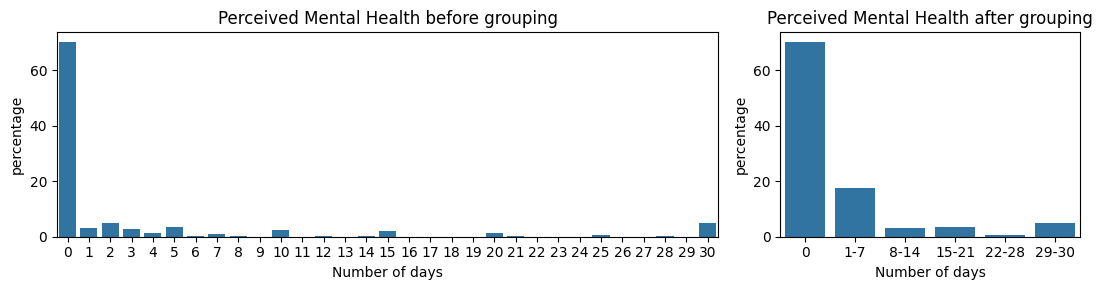

In [152]:
compare_day_grouping("MentHlth", "MentHlth_group", "Perceived Mental Health")

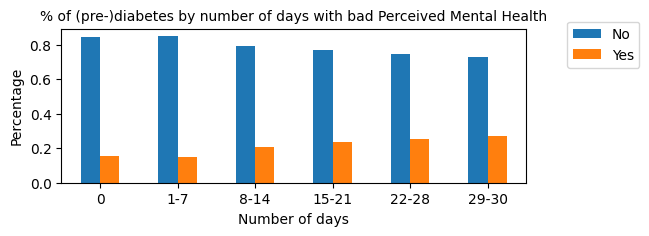

In [153]:
fig, ax = plt.subplots(figsize=(6, 2))
df = pd.crosstab(df0["MentHlth_group"], df0["target"], dropna=False, normalize="index")
ax = df.plot.bar(rot=0,ax=ax)
ax.set_xlabel("Number of days")
ax.set_ylabel("Percentage")
ax.set_title("% of (pre-)diabetes by number of days with bad Perceived Mental Health", fontsize=10)
ax.legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.1,0.95), bbox_transform=plt.gcf().transFigure)
plt.show()

##### PhysHlth

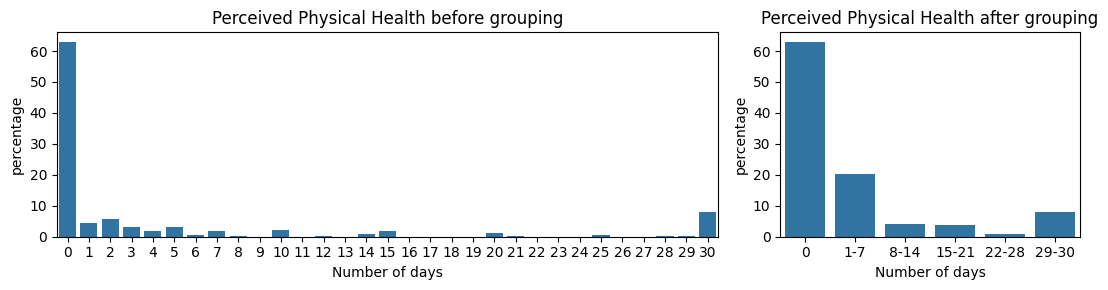

In [154]:
compare_day_grouping("PhysHlth", "PhysHlth_group", "Perceived Physical Health")

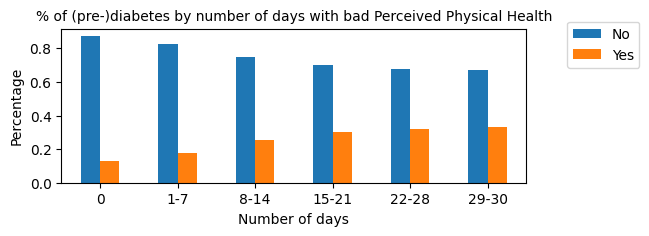

In [155]:
fig, ax = plt.subplots(figsize=(6, 2))
df = pd.crosstab(df0["PhysHlth_group"], df0["target"], dropna=False, normalize="index")
ax = df.plot.bar(rot=0,ax=ax)
ax.set_xlabel("Number of days")
ax.set_ylabel("Percentage")
ax.set_title("% of (pre-)diabetes by number of days with bad Perceived Physical Health", fontsize=10)
ax.legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.1,0.95), bbox_transform=plt.gcf().transFigure)
plt.show()

#### Lifestyle
* There are 6 variables related to lifestyle: `CholCheck`_(binary)_, `Smoker`_(binary)_, `PhysActivity`_(binary)_, `Fruits`_(binary)_, `Veggies`_(binary)_, `HvyAlcoholConsump`_(binary)_

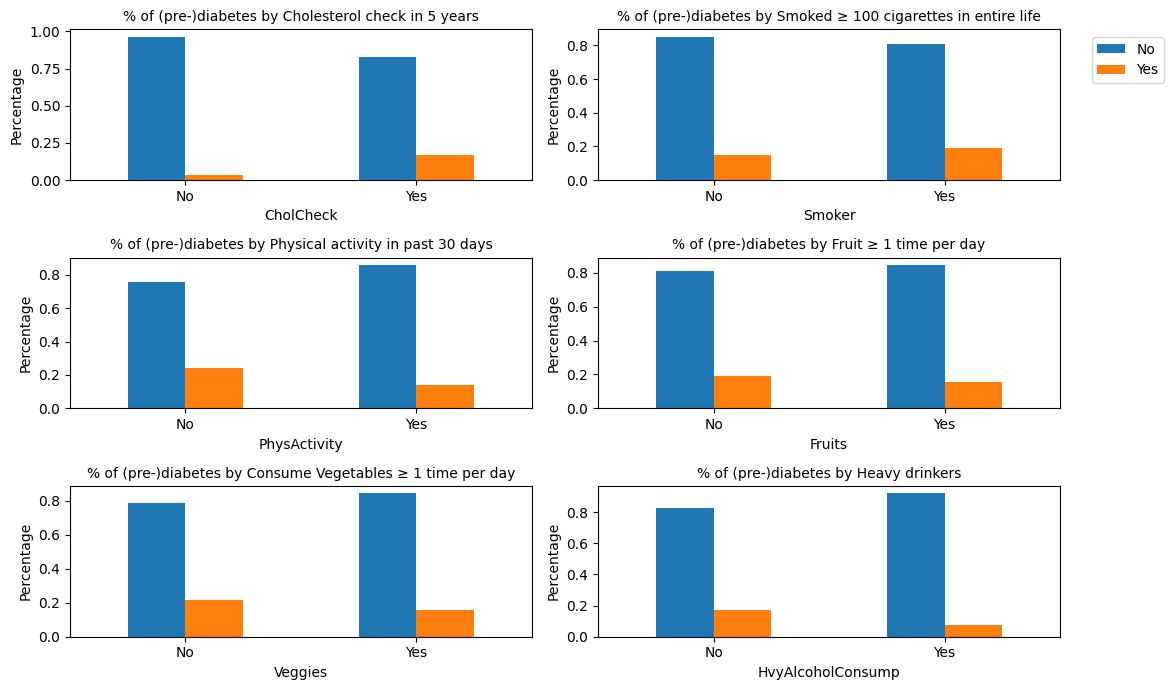

In [156]:
features = ["CholCheck", "Smoker", "PhysActivity", "Fruits", "Veggies", "HvyAlcoholConsump"]
titles = ["Cholesterol check in 5 years", "Smoked ≥ 100 cigarettes in entire life", "Physical activity in past 30 days", "Fruit ≥ 1 time per day", "Consume Vegetables ≥ 1 time per day", "Heavy drinkers"]
titles = ["% of (pre-)diabetes by " + title for title in titles]
plot_binary(df0, "target", features, titles, grid_shape=(3, 2), figure_size=(12, 7), bounding_box=(0.98, 0.95))

In [157]:
pd.crosstab(df0.HvyAlcoholConsump, df0.target, normalize="index")

target,No,Yes
HvyAlcoholConsump,,
0.0,0.828435,0.171565
1.0,0.922044,0.077956


#### Financial difficulty
* There are 2 variables related to financial difficulty: `AnyHealthcare`_(binary)_ and `NoDocbcCost`_(binary)_

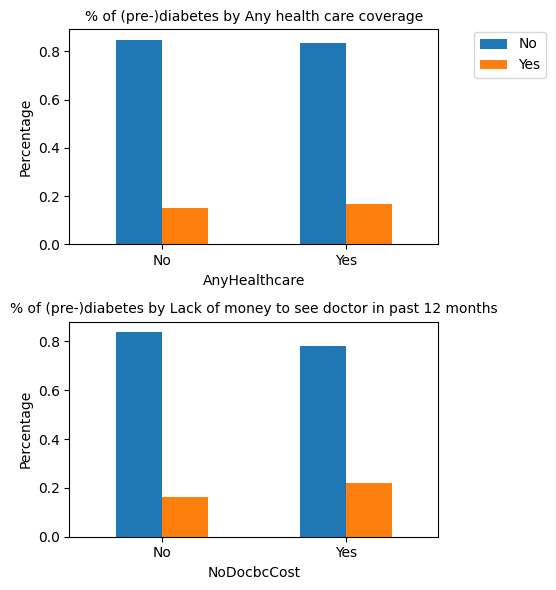

In [158]:
features = ["AnyHealthcare", "NoDocbcCost"]
titles = ["Any health care coverage", "Lack of money to see doctor in past 12 months"]
titles = ["% of (pre-)diabetes by " + title for title in titles]
plot_binary(df0, "target", features, titles, grid_shape=(2, 1), figure_size=(5, 6), bounding_box=(1.1, 0.95))

#### Demographic
* There are 4 demographic variables: `Sex`_(binary)_, `Age`_(ordinal)_, `Education`_(ordinal)_, `Income`_(ordinal)_

##### Sex

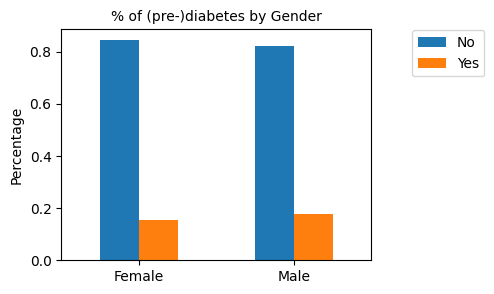

In [159]:
df_crosstab = pd.crosstab(df0["Sex"].map(mapping_gender), df0["target"], dropna=False, normalize="index")
fig, ax = plt.subplots(figsize=(4, 3))
df_crosstab.plot.bar(rot=0, ax=ax)
ax.set_xlabel("")
ax.set_ylabel("Percentage")
ax.set_title("% of (pre-)diabetes by Gender", fontsize=10)
ax.legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.2, 0.9), bbox_transform=plt.gcf().transFigure)
plt.show()

##### Age, Education, Income

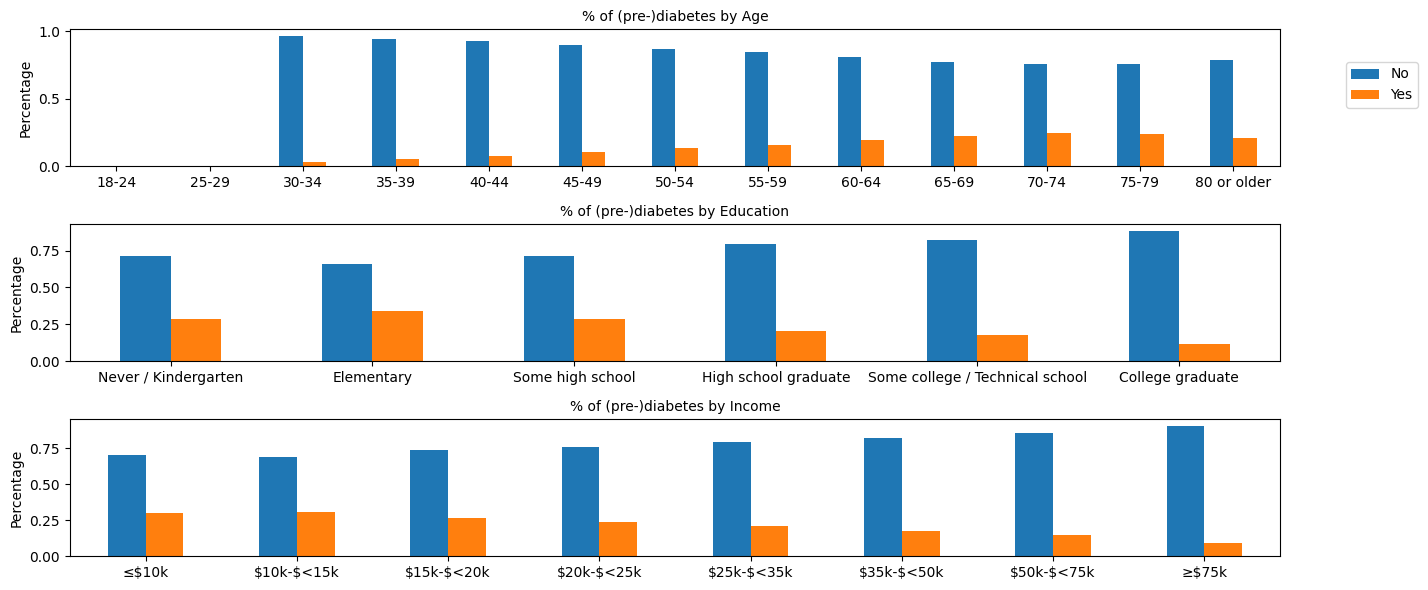

In [160]:
fig, axes = plt.subplots(3, 1, figsize=(13, 6))
axes = axes.flatten()

y = df0["target"]

cat_type = pd.CategoricalDtype(categories=order_age, ordered=True)
x = df0["Age"].map(mapping_age).astype(cat_type)
df_crosstab = pd.crosstab(x, y, dropna=False, normalize="index")
df_crosstab.plot.bar(rot=0, ax=axes[0])
axes[0].set_xlabel("")
axes[0].set_ylabel("Percentage")
axes[0].set_title("% of (pre-)diabetes by Age", fontsize=10)
axes[0].legend().remove()

cat_type = pd.CategoricalDtype(categories=order_edu, ordered=True)
x = df0["Education"].map(mapping_edu).astype(cat_type)
df_crosstab = pd.crosstab(x, y, dropna=False, normalize="index")
df_crosstab.plot.bar(rot=0, ax=axes[1])
axes[1].set_xlabel("")
axes[1].set_ylabel("Percentage")
axes[1].set_title("% of (pre-)diabetes by Education", fontsize=10)
axes[1].legend().remove()

cat_type = pd.CategoricalDtype(categories=order_income, ordered=True)
x = df0["Income"].map(mapping_income).astype(cat_type)
df_crosstab = pd.crosstab(x, y, dropna=False, normalize="index")
df_crosstab.plot.bar(rot=0, ax=axes[2])
axes[2].set_xlabel("")
axes[2].set_ylabel("Percentage")
axes[2].set_title("% of (pre-)diabetes by Income", fontsize=10)
axes[2].legend().remove()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.1, 0.9), bbox_transform=plt.gcf().transFigure)

plt.tight_layout()
plt.show()

In [161]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Index: 238501 entries, 0 to 251701
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Diabetes_binary       238501 non-null  float64 
 1   HighBP                238501 non-null  float64 
 2   HighChol              238501 non-null  float64 
 3   CholCheck             238501 non-null  float64 
 4   BMI                   238501 non-null  float64 
 5   Smoker                238501 non-null  float64 
 6   Stroke                238501 non-null  float64 
 7   HeartDiseaseorAttack  238501 non-null  float64 
 8   PhysActivity          238501 non-null  float64 
 9   Fruits                238501 non-null  float64 
 10  Veggies               238501 non-null  float64 
 11  HvyAlcoholConsump     238501 non-null  float64 
 12  AnyHealthcare         238501 non-null  float64 
 13  NoDocbcCost           238501 non-null  float64 
 14  GenHlth               238501 non-null  fl